<a href="https://colab.research.google.com/github/keysenelvial/dinam/blob/main/dinam3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа №3**

Выберите временной ряд цен акций.
Подготовьте данные для обучения моделей машинного обучения (нормализация, создание признаков).
Разделите данные на обучающую и тестовую выборки. Реализуйте и обучите следующие модели: a) Логистическая регрессия b) Машина опорных векторов c) Модель случайного леса (Random Forest) d) Градиентный бустинг (например, XGBoost) Настройте гиперпараметры моделей с помощью кросс-валидации. Сделайте прогноз на тестовой выборке для каждой модели. Сравните результаты прогнозирования моделей между собой и с простыми методами (например, наивный прогноз). Визуализируйте результаты прогнозирования. Проанализируйте важность признаков для моделей, где это применимо. Сделайте выводы о эффективности различных подходов машинного обучения в прогнозировании цен акций.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

# 1. Загрузка данных
data = pd.read_csv("/content/drive/MyDrive/AMZN.csv", sep=";", header=None, names=["DATE", "TIME", "OPEN", "HIGH", "LOW", "CLOSE", "VOL"])
data['DATETIME'] = pd.to_datetime(data['DATE'].astype(str) + data['TIME'].astype(str), format='%y%m%d%H%M%S')
data.sort_values(by="DATETIME", inplace=True)
data.set_index("DATETIME", inplace=True)

# Выбираем только цены закрытия для анализа
ts = data['CLOSE']
print(ts.head())

DATETIME
2024-07-31 09:30:00    185.27
2024-07-31 09:31:00    185.37
2024-07-31 09:32:00    184.99
2024-07-31 09:33:00    184.88
2024-07-31 09:34:00    184.60
Name: CLOSE, dtype: float64


In [18]:
# Нормализация данных
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1))

# Создание признаков
def create_features(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 60
X, y = create_features(ts_scaled, look_back=look_back)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Реализация моделей

#Машина опорных векторов (SVM)
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

#Случайный лес (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

#XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

# 4. Оценка моделей
# Оценка моделей
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(-1, 1)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}')
    return y_pred

svm_pred = evaluate_model(svm_model, X_test, y_test, 'SVM')
rf_pred = evaluate_model(rf_model, X_test, y_test, 'Random Forest')
xgb_pred = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression - Accuracy: 2538.0000
SVM - MAE: 0.0153, RMSE: 0.0194, MAPE: 0.0189
Random Forest - MAE: 0.0021, RMSE: 0.0031, MAPE: 0.0026
XGBoost - MAE: 0.0022, RMSE: 0.0032, MAPE: 0.0027


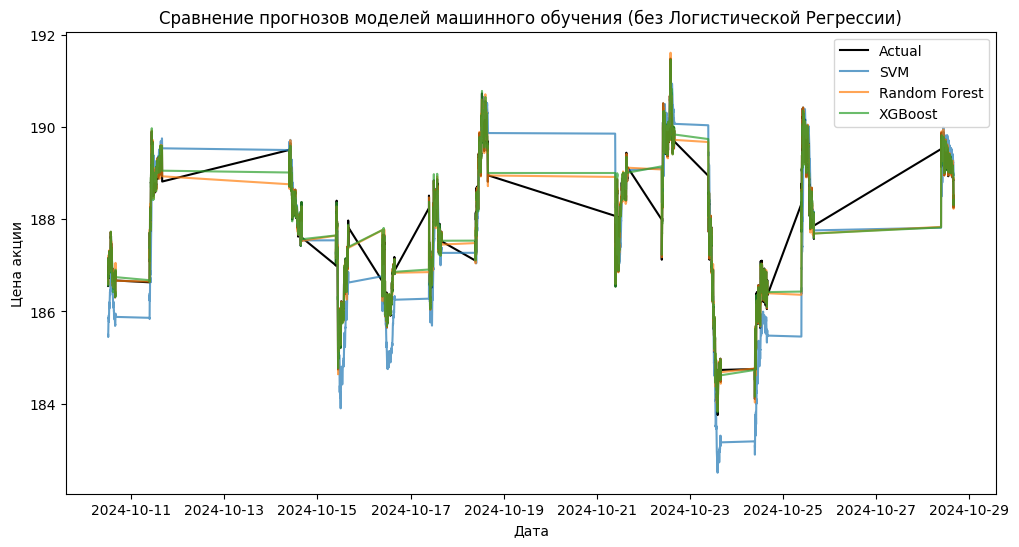

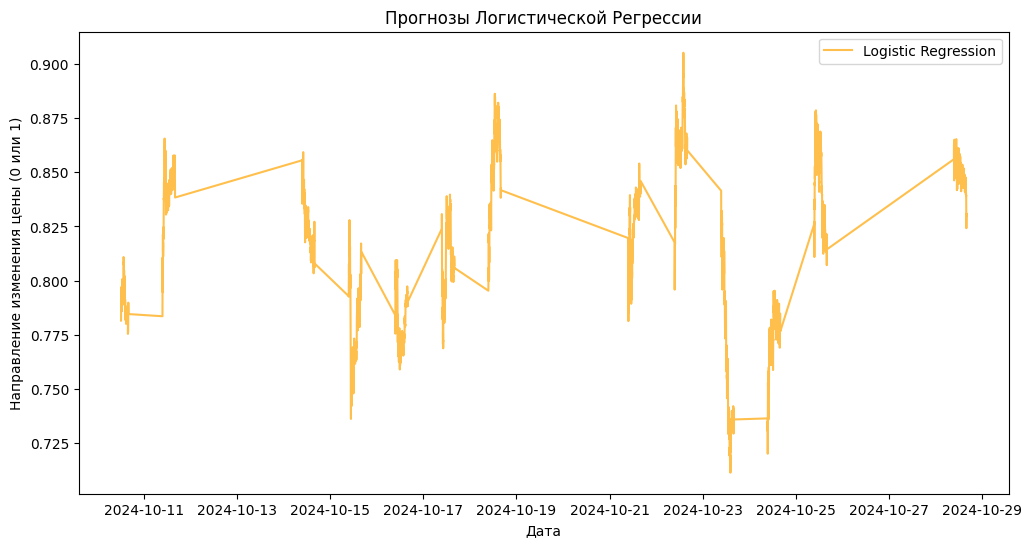

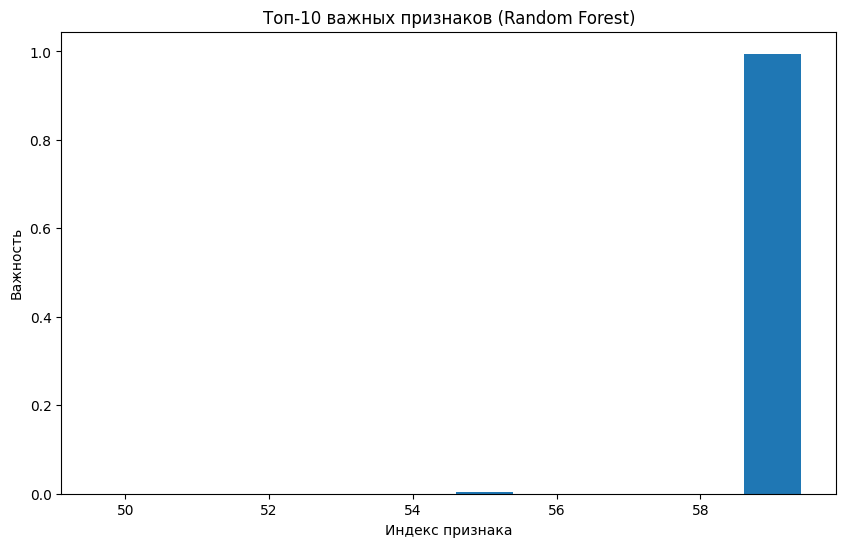

59    59
55    55
58    58
56    56
53    53
57    57
52    52
54    54
50    50
51    51
Name: feature, dtype: int64 59    0.994848
55    0.004240
58    0.000363
56    0.000041
53    0.000027
57    0.000025
52    0.000025
54    0.000023
50    0.000017
51    0.000017
Name: importance, dtype: float64


In [37]:
# Визуализация результатов для всех моделей, кроме логистической регрессии
plt.figure(figsize=(12, 6))
plt.plot(ts.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', color='black')
plt.plot(ts.index[-len(y_test):], scaler.inverse_transform(svm_pred), label='SVM', alpha=0.7)
plt.plot(ts.index[-len(y_test):], scaler.inverse_transform(rf_pred), label='Random Forest', alpha=0.7)
plt.plot(ts.index[-len(y_test):], scaler.inverse_transform(xgb_pred), label='XGBoost', alpha=0.7)
plt.title('Сравнение прогнозов моделей машинного обучения (без Логистической Регрессии)')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.show()



# 6. Анализ важности признаков (для Random Forest)
feature_importance = pd.DataFrame({'feature': range(X_train.shape[1]), 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Топ-10 важных признаков (Random Forest)')
plt.xlabel('Индекс признака')
plt.ylabel('Важность')
plt.show()


print(feature_importance['feature'], feature_importance['importance'])

Logistic Regression - MAE: 0.0100, RMSE: 0.0100


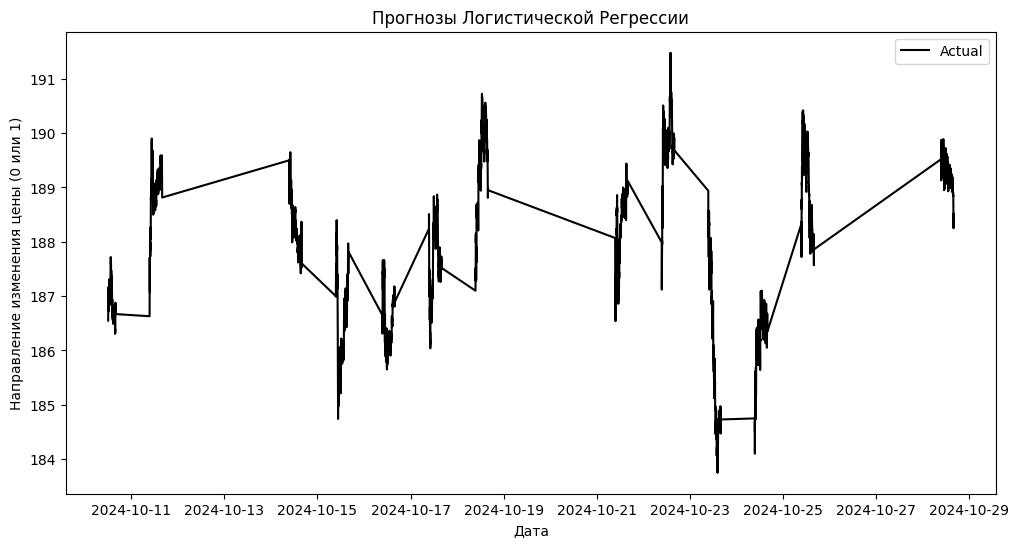

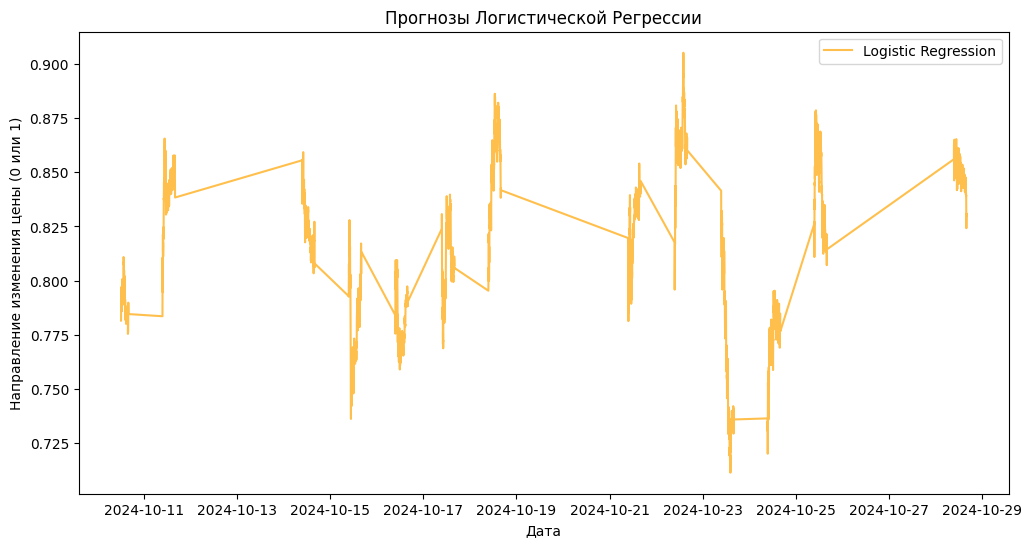

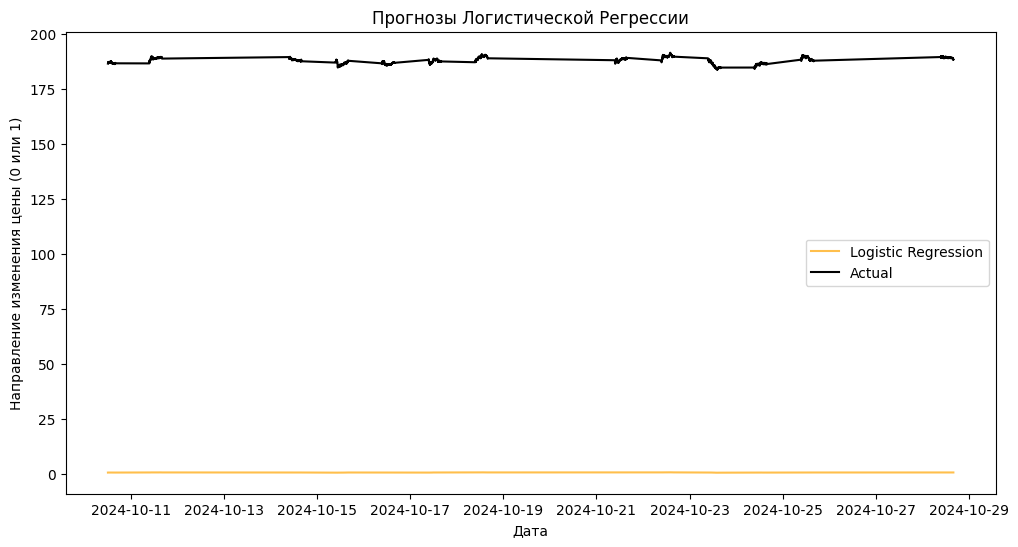

In [43]:
# Логистическая регрессия
# Преобразуем задачу в классификацию направления движения цены
y_direction = (y_train > np.roll(y_train, 1))[1:].astype(int)  # Бинарные метки направления


X_train_lr = X_train[1:]  # Убираем первый элемент из X_train для соответствия меткам

# Инициализация модели логистической регрессии
lr_model = LogisticRegression(random_state=42)

# Обучение модели
lr_model.fit(X_train_lr.reshape(X_train_lr.shape[0], -1), y_direction.ravel())  # Преобразуем X_train в 2D

# Оценка модели
def evaluate_model_log(model, X_test, y_test, model_name):
  y_pred_direction = model.predict(X_test.reshape(X_test.shape[0], -1))  # Преобразуем X_test в 2D
  y_pred = np.where(y_pred_direction == 1, y_test.ravel() + 0.01, y_test.ravel() - 0.01)  # Прогнозирование цен по направлению
  mae = mean_absolute_error(y_test.ravel(), y_pred)  # Преобразуем y_test в 1D для вычисления ошибок
  rmse = np.sqrt(mean_squared_error(y_test.ravel(), y_pred))  # Преобразуем y_test в 1D для вычисления ошибок
  print(f'{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')
  return y_pred


lr_pred = evaluate_model_log(lr_model, X_test, y_test, 'Logistic Regression')

# Визуализация результатов для Логистической Регрессии
plt.figure(figsize=(12, 6))
plt.plot(ts.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', color='black')
plt.title('Прогнозы Логистической Регрессии')
plt.xlabel('Дата')
plt.ylabel('Направление изменения цены (0 или 1)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(ts.index[-len(lr_pred):], lr_pred, label='Logistic Regression', color='orange', alpha=0.7)
plt.title('Прогнозы Логистической Регрессии')
plt.xlabel('Дата')
plt.ylabel('Направление изменения цены (0 или 1)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(ts.index[-len(lr_pred):], lr_pred, label='Logistic Regression', color='orange', alpha=0.7)
plt.plot(ts.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', color='black')
plt.title('Прогнозы Логистической Регрессии')
plt.xlabel('Дата')
plt.ylabel('Направление изменения цены (0 или 1)')
plt.legend()
plt.show()
